## Import

In [61]:
# Import internal modules
import os.path
import joblib
import time
from typing import List, Set, Dict, TypedDict, Tuple, Optional

# Import 3rd party modules
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, recall_score
# from sklearn.externals import joblib
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report

## Load dataset

In [9]:
df = pd.read_csv(os.path.join("assets","data","thread_csv_all.csv"))
df.head()

,noise_db,machine_type,model_id,sound,sound_path,target,spect_mean,spect_min,spect_max,spect_std,...,zero_crossing_rate_max,zero_crossing_rate_std,d_harmonic_mean,d_harmonic_min,d_harmonic_max,d_harmonic_std,d_percussive_mean,d_percussive_min,d_percussive_max,d_percussive_std
0,-6,slider,0,00000000.wav,assets\sounds\-6_dB_slider\slider\id_00\abnorm...,abnormal,0.107133,1.922508e-11,8.000317,0.286640,...,0.125488,0.015289,0.059173,1.413419e-12,7.861723,0.217199,0.047960,1.447360e-11,2.427006,0.102428
1,-6,slider,0,00000001.wav,assets\sounds\-6_dB_slider\slider\id_00\abnorm...,abnormal,0.091550,1.239772e-10,11.825641,0.306949,...,0.122559,0.022209,0.051675,1.856747e-13,11.707416,0.261016,0.039876,7.817087e-11,2.639281,0.086876
2,-6,slider,0,00000002.wav,assets\sounds\-6_dB_slider\slider\id_00\abnorm...,abnormal,0.114412,2.546376e-10,8.061798,0.300529,...,0.107422,0.013853,0.061442,5.859085e-13,7.840732,0.220184,0.052971,7.954731e-11,2.856351,0.114448
3,-6,slider,0,00000003.wav,assets\sounds\-6_dB_slider\slider\id_00\abnorm...,abnormal,0.108589,6.224236e-11,7.651740,0.277428,...,0.125488,0.012602,0.064017,1.636899e-13,7.523073,0.240022,0.044573,2.057399e-11,1.847202,0.077006
4,-6,slider,0,00000004.wav,assets\sounds\-6_dB_slider\slider\id_00\abnorm...,abnormal,0.107343,9.855214e-12,7.804570,0.287012,...,0.119141,0.010417,0.064301,1.400486e-13,7.756195,0.248836,0.043042,4.824911e-12,2.022621,0.079337


## Feature engineering 

In [49]:
# replace abnormal by 1, normal by 0
df.target = df.target.apply(lambda x: 1 if x == "abnormal" else 0)

## Feature selection

In [71]:
# ## select numeric columns
# selected_cols = df.select_dtypes(include="number").columns.tolist()

# ## drop noise_db and model_id columns
# selected_cols.remove("noise_db")
# selected_cols.remove("model_id")

# print(selected_cols)

selected_cols = [
"rms_std",
"rms_max",
"d_percussive_max",
"d_percussive_std",
"chroma_min",
"mel_spect_std",
"cent_std",
"tonnetz_mean",
"zero_crossing_rate_std",
"spect_mean",
"tonnetz_std",
"roll_off_max",
"tonnetz_max",
"chroma_cq_mean",
"chroma_cens_max",
"contrast_min",
"chroma_mean",
"spec_bw_mean",
"tonnetz_min",
"zero_crossing_rate_mean",
]

In [90]:
# Select features X and target variable y
X = df[selected_cols]
y = df.target

## Split dataset

In [73]:
# # Split into training, validation and test sets
# ## Specify fractions of entire of dataset
# train_fraction = 0.75
# validation_fraction = 0.15
# test_fraction = 0.10

# ## Split into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X,
#                                                     y,
#                                                     test_size=1 - train_fraction,
#                                                     random_state=42,
#                                                     stratify=y
#                                                    )

# ## Split the test sets into validation and test sets
# X_val, X_test, y_val, y_test = train_test_split(X_test,
#                                                 y_test,
#                                                 test_size=test_fraction/(test_fraction + validation_fraction),
#                                                 random_state=42,
#                                                 stratify=y_test
#                                                )

# print(f"X_train: {X_train.shape}   - y_train: {y_train.shape}")
# print(f"X_val:   {X_val.shape}    - y_train: {y_val.shape}")
# print(f"X_test:  {X_test.shape}    - y_train: {y_test.shape}")


X_train: (40542, 20)   - y_train: (40542,)
X_val:   (8109, 20)    - y_train: (8109,)
X_test:  (5406, 20)    - y_train: (5406,)


In [91]:
# Split into training and test sets

## Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y
                                                   )

print(f"X_train: {X_train.shape}   - y_train: {y_train.shape}")
print(f"X_test:  {X_test.shape}    - y_train: {y_test.shape}")


X_train: (43245, 20)   - y_train: (43245,)
X_test:  (10812, 20)    - y_train: (10812,)


In [ ]:
# create feature union
# features = []
# features.append(('pca', PCA(n_components=3)))
# features.append(('select_best', SelectKBest(k=6)))
# feature_union = FeatureUnion(features)
# create pipeline
# estimators = []
# estimators.append(('feature_union', feature_union))
# estimators.append(('logistic', LogisticRegression()))
# model = Pipeline(estimators)
# # evaluate pipeline
# seed = 7
# kfold = KFold(n_splits=10, random_state=seed)
# results = cross_val_score(model, X, Y, cv=kfold)
# print(results.mean())

## Models

In [81]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [98]:
from sklearn.model_selection import StratifiedKFold
cv_stratified = StratifiedKFold(n_splits=10)

In [115]:
# 1. Create pipelines
pipe_random_forest = make_pipeline(RandomForestClassifier(random_state=5))
pipe_decision_tree = make_pipeline(DecisionTreeClassifier(random_state=5))
pipe_svm = make_pipeline(SVC(random_state=5))
pipe_logistic_regression = make_pipeline(LogisticRegression(random_state=5))
pipe_balanced_random_forest = make_pipeline(BalancedRandomForestClassifier(random_state=5))


# 2. GridSearchCV for each pipeline: to train models with different parameters
# and get the best models (for each pipeline) with the best parameters

## 2.1 Define grid search parameters
grid_params_random_forest = {
    'randomforestclassifier__n_estimators': [90, 100, 110],
    'randomforestclassifier__criterion': ['gini', 'entropy']
}
#                               'clf__max_depth': param_range,
#                               'clf__min_samples_split': param_range[1:]}]
grid_params_decision_tree = {
    'decisiontreeclassifier__criterion': ['gini', 'entropy']
}

grid_params_svm = {
    'svc__kernel': ['linear', 'rbf'],
    'svc__C': [9, 10]
}

grid_params_logistic_regression = {
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__C': [1.0, 0.5],
    'logisticregression__solver': ['liblinear']
}

grid_params_balanced_random_forest = {
    'balancedrandomforestclassifier__n_estimators': [90, 100, 110],
    'balancedrandomforestclassifier__criterion': ['gini', 'entropy']
}

## 2.2 Instantiate grid searches
### set n_jobs to -1 to use all processors
n_jobs: int = 3

grid_random_forest = GridSearchCV(
    estimator=pipe_random_forest,
    param_grid=grid_params_random_forest,
    scoring='recall',
    # cv=10,
    cv=cv_stratified,
    n_jobs=n_jobs
)

grid_decision_tree = GridSearchCV(
    estimator=pipe_decision_tree,
    param_grid=grid_params_decision_tree,
    scoring='recall',
    # cv=10,
    cv=cv_stratified,
    n_jobs=n_jobs
)

grid_svm = GridSearchCV(
    estimator=pipe_svm,
    param_grid=grid_params_svm,
    scoring='recall',
    # cv=10,
    cv=cv_stratified,
    n_jobs=n_jobs
)

grid_random_logistic_regression = GridSearchCV(
    estimator=pipe_logistic_regression,
    param_grid=grid_params_logistic_regression,
    scoring='recall',
    # cv=10,
    cv=cv_stratified,
)

grid_balanced_random_forest = GridSearchCV(
    estimator=pipe_balanced_random_forest,
    param_grid=grid_params_balanced_random_forest,
    scoring='recall',
    # cv=10,
    cv=cv_stratified,
    n_jobs=n_jobs
)

In [103]:
## 2.3 Create dict of grids
grids: Dict[str, GridSearchCV] = {
    "random_forest": grid_random_forest,
    "decision_tree": grid_decision_tree,
    #"svm": grid_svm,
    "logistic_regression": grid_random_logistic_regression,
    "balanced_random_forest": grid_balanced_random_forest
}

# 2.4 Keep track of the best accuracy score
best_recall = 0.0
best_model = None
best_model_name = ""    
    
## 2.4 Fit the grids to the training set
for grid_name, grid in grids.items():
    start_time = time.time()
    print(f"Fitting training with {grid_name}")
    grid.fit(X_train, y_train)
    print(f'best params: {grid.best_params_}')
    print(f'best training recall: {grid.best_score_}')
    
    # predict on test set with best parameters
    y_pred = grid.predict(X_test)
    recall_score_value = recall_score(y_test, y_pred)
    print(f'recall_score on test set with best parameters: {recall_score_value}')
    
    # Update the best model
    if recall_score_value > best_recall:
        best_recall = recall_score_value
        best_model = grid
        best_model_name = grid_name
    
    # Print time to select best model within a grid
    end_time = time.time()
    diff_time_m = (end_time - start_time)/60
    print(f"Time to select best {grid_name}: {diff_time_m:.2f} minutes")
print(f"Conclusion: model with best recall on test set: {best_model_name}")

Fitting training with balanced_random_forest
best params: {'balancedrandomforestclassifier__criterion': 'entropy', 'balancedrandomforestclassifier__n_estimators': 90}
best training recall: 0.843939393939394
recall_score on test set with best parameters: 0.8550505050505051
Time to select best balanced_random_forest: 2.33 minutes
Conclusion: model with best recall on test set: balanced_random_forest


In [116]:
## 2.3 Create dict of grids
grids: Dict[str, GridSearchCV] = {
    "random_forest": grid_random_forest,
    "decision_tree": grid_decision_tree,
    #"svm": grid_svm,
    "logistic_regression": grid_random_logistic_regression,
    "balanced_random_forest": grid_balanced_random_forest
}

# 2.4 Keep track of the best accuracy score
best_recall = 0.0
best_model = None
best_model_name = ""    
    
## 2.4 Fit the grids to the training set
for grid_name, grid in grids.items():
    start_time = time.time()
    print(f"Fitting training with {grid_name}")
    grid.fit(X_train, y_train)
    print(f'best params: {grid.best_params_}')
    print(f'best training recall: {grid.best_score_}')
    
    # predict on test set with best parameters
    y_pred = grid.predict(X_test)
    recall_score_value = recall_score(y_test, y_pred)
    print(f'recall_score on test set with best parameters: {recall_score_value}')
    
    # Update the best model
    if recall_score_value > best_recall:
        best_recall = recall_score_value
        best_model = grid
        best_model_name = grid_name
    
    # Print time to select best model within a grid
    end_time = time.time()
    diff_time_m = (end_time - start_time)/60
    print(f"Time to select best {grid_name}: {diff_time_m:.2f} minutes")
print(f"Conclusion: model with best recall on test set: {best_model_name}")

Fitting training with random_forest
best params: {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__n_estimators': 90}
best training recall: 0.6272727272727272
recall_score on test set with best parameters: 0.6383838383838384
Time to select best random_forest: 6.82 minutes
Fitting training with decision_tree
best params: {'decisiontreeclassifier__criterion': 'gini'}
best training recall: 0.6843434343434345
recall_score on test set with best parameters: 0.694949494949495
Time to select best decision_tree: 0.19 minutes
Fitting training with logistic_regression
best params: {'logisticregression__C': 1.0, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
best training recall: 0.11641414141414139
recall_score on test set with best parameters: 0.1111111111111111
Time to select best logistic_regression: 0.92 minutes
Fitting training with balanced_random_forest
best params: {'balancedrandomforestclassifier__criterion': 'entropy', 'balancedra

In [117]:
## 2.5 Save the best grid search pipeline to pkl file
filepath = os.path.join("assets","data","best_model.joblib")
joblib.dump(best_model, filepath, compress=1)
print(f"Best model ({best_model_name}) is saved")

# ## 2.5 Save the best grid search pipeline to sav file
# filepath = os.path.join("assets","data","best_model.sav")
# pickle.dump(best_model, open(filepath, 'wb'))

## Load the model
loaded_model = joblib.load(filepath) 

# # Load the model
# loaded_model = pickle.load(open(filepath, 'rb'))
# result = loaded_model.score(X_test, y_test)
print(loaded_model)
print(classification_report(y_test, loaded_model.predict(X_test)))

Best model (balanced_random_forest) is saved
GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('balancedrandomforestclassifier',
                                        BalancedRandomForestClassifier(random_state=5))]),
             n_jobs=3,
             param_grid={'balancedrandomforestclassifier__criterion': ['gini',
                                                                       'entropy'],
                         'balancedrandomforestclassifier__n_estimators': [90,
                                                                          100,
                                                                          110]},
             scoring='recall')
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      8832
           1       0.66      0.86      0.75      1980

    accuracy                           0.89     10812
   macro avg       0.81      0.88     

In [ ]:
# numeric_transformer = make_pipeline(StandardScaler())
# category_transformer = make_pipeline(OneHotEncoder())

In [105]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, loaded_model.predict(X_test))

array([[7962,  870],
       [ 287, 1693]])

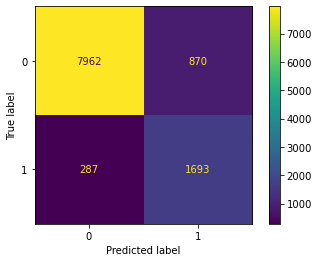

In [107]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(loaded_model, X_test, y_test);

In [114]:
X_test.iloc[[1]]

,rms_std,rms_max,d_percussive_max,d_percussive_std,chroma_min,mel_spect_std,cent_std,tonnetz_mean,zero_crossing_rate_std,spect_mean,tonnetz_std,roll_off_max,tonnetz_max,chroma_cq_mean,chroma_cens_max,contrast_min,chroma_mean,spec_bw_mean,tonnetz_min,zero_crossing_rate_mean
28489,0.000907,0.008228,3.090454,0.075248,0.184796,0.092794,127.90084,-0.02459,0.006872,0.074043,0.080171,5943.164062,0.143502,0.515873,0.57216,5.040021,0.552856,1406.862854,-0.296043,0.050134


In [112]:
loaded_model.predict(X_test.iloc[[1]])

array([0])

In [113]:
y_test.iloc[[1]]

28489    0
Name: target, dtype: int64